In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import qmc
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct, RationalQuadratic, Matern
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set()
import emcee
from emcee import EnsembleSampler
import corner
import time

In [2]:
# global variables
# nsamples
# number of kinematical points
# number of parameters
# scaler
# pca
# gpe

In [3]:
# function to train PCA and GPE, returns trained PCA, GPE, SS

ss = StandardScaler()

def train_PCA_GPE(training_data, theta, primary_components = 2): 

    training_data_scaled = ss.fit_transform(training_data)    
    pca = PCA(n_components = primary_components, whiten = True)
    training_data_PCAd = pca.fit_transform(training_data_scaled)
    gpes = []
    
    for z in training_data_PCAd.T[:primary_components]: # optimize hyper parameters for each pc
        kernel = 1 * RBF(length_scale = 1 * np.ones(theta.shape[1])) #+ 1 * WhiteKernel()
        gpe = GaussianProcessRegressor(kernel = kernel, copy_X_train = False) #, normalize_y = True)
        gpes.append(gpe.fit(theta, z))
    return gpes, pca, ss

def invert_cov(cov, var_trans, nsamples, nkp):
    return np.dot(np.array(cov).T, var_trans).reshape(nsamples, nkp, nkp) # A.T * cov * A ?

def return_predictions(emulators, theta, return_std_ = True):
    gpes = emulators[0]
    pca = emulators[1]
    ss = emulators[2]
    nsamples = len(theta)
    npc = len(gpes) # number of principal components
    nkp = np.shape(ss.scale_)[0] # number of kinematical points
                   
    mean_prediction = []
    cov_prediction = []
    
    for gpe in gpes: # predicts per principal component: len(gpes) = npc 
        
        mean, cov = gpe.predict(theta, return_cov = return_std_)
        gp_var2 = cov.diagonal()[:, np.newaxis]
        
        mean_prediction.append(mean)
        cov_prediction.append(gp_var2)

    # inverse transform mean prediction
    pred_r = ss.inverse_transform(pca.inverse_transform(np.array(mean_prediction).T))
    
    # make transformation matrix for error
    trans_matrix = pca.components_ * np.sqrt(pca.explained_variance_[:, np.newaxis]) # transformation matrix
    A = trans_matrix[:npc] 
    var_trans = np.einsum('ki,kj->kij', A, A, optimize = False).reshape(npc, nkp**2)
    
    # inverse transform diagonal covariance matrix
    st1 = time.time()
    cov_rpca = invert_cov(cov_prediction, var_trans, nsamples, nkp)
    et1 = time.time()
    std_preds = np.sqrt(np.diagonal(cov_rpca, axis1 = 1, axis2 = 2)) # standard devs are just
    err_r = ss.scale_ * std_preds 
    return pred_r, err_r

# log formulas

# log likelihood
def log_likelihood(theta, emulators, data, data_err): # one set of theta only
    theta_reshaped = theta.reshape(1,-1)
    predict, predict_err = return_predictions(emulators, theta_reshaped, return_std_ = True)    
    err2 = (predict_err**2 + (data_err)**2) 
    ll = np.log(2*np.pi*err2) + ((data - predict)**2) / err2 #np.log is natural log 
    return -.5*np.sum(ll)

# some flat prior that sets the bounds of the parameters
def log_flat_prior(theta, l_bounds, u_bounds):
    
    for i in range(np.size(theta)): # check if each parameter is within bounds
        if theta[i] < l_bounds[i] or theta[i] > u_bounds[i]:
            return -np.inf
       
    return 0

# posterior
def log_posterior(theta, l_bounds, u_bounds, emulators, data, data_err):
    return log_likelihood(theta, emulators, data, data_err) + log_flat_prior(theta, l_bounds, u_bounds)

# emcee sampler function
def emcee_sampler(n_walkers, n_params, log_posterior, l_bounds, u_bounds, emulators, data, data_err):
    sampler = EnsembleSampler(n_walkers, n_params, log_posterior, args = [l_bounds, u_bounds, emulators, data, data_err]) # default is stretchmove
    return sampler

def return_samples(p0, l_bounds, u_bounds, n_walkers, n_params, n_samples, n_burn, sampler):
    burn = sampler.run_mcmc(p0, n_burn, progress = True) # initially train until samples converge
    sampler.reset() # remove burn samples
    run = sampler.run_mcmc(burn, n_samples, progress = True)
    return sampler.get_chain(flat = True)

In [4]:
#fig_label = "4p100d232k"
#train_file, theta_file, exp_file = ["trainingdata4p100d232k.dat", 
#                                    "trainingdata4p100d_theta.dat", 
#                                    "trainingdata4p100d232k_exp.dat"]

folder = "mv" # w3p20d
train_file, theta_file, exp_file = [folder + "/train.dat", folder + "/theta.dat", folder + "/exp.dat"]

param_names = [r"$Q_{s0}^{2}$ (GeV²)",
               #r"$e_c$",
               r"$log C^{2}$",
               r"$\sigma_0/2$ (mb)"] # ordered

# cut training data ()
exp_df = pd.DataFrame(np.loadtxt(exp_file), columns = ['xbj', 'Qs2', 'sqrt(s)', 'sigma_r', 'error'])
a, b = 2.0, 50.0 
# Q2_region = exp_df['Qs2'] < 10.0 # boolean
Q2_region = (exp_df['Qs2'] > a) & (exp_df['Qs2'] < b)
Q2_index = exp_df.index[Q2_region].tolist()
exp_df = exp_df[Q2_region]
exp = np.array(exp_df['sigma_r'])
exp_err = np.array(exp_df['error'])

FileNotFoundError: w3p50d/exp.dat not found.

In [ ]:
train_dataset = pd.DataFrame(np.loadtxt(train_file))
train_dataset = train_dataset.iloc[:, Q2_index].T.reset_index(drop=True).T
params_all = np.vstack(np.loadtxt(theta_file, unpack = True)).T
n_params = len(param_names)
training_set_all = train_dataset.iloc[:,np.array(train_dataset.columns)].values
myparams, myparams_test, training_set, training_set_test = train_test_split(params_all, 
                                                                            training_set_all, 
                                                                            test_size = 0.20, 
                                                                            random_state = 10)

In [ ]:
# train pca, scaler, and gpe
npc = 8
emulators = train_PCA_GPE(training_set, myparams, primary_components = npc)
# return predictions of fits
pred_r, err_r = return_predictions(emulators, myparams_test, return_std_ = True)

/home/caaucasu/.conda/envs/myenv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [ ]:
import_module = "import numpy as np; import matplotlib.pyplot as plt; import pandas as pd;from sklearn.decomposition import PCA;from sklearn.preprocessing import StandardScaler;from scipy.stats import qmc;from sklearn.gaussian_process import GaussianProcessRegressor;from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct, RationalQuadratic, Matern;from sklearn.model_selection import train_test_split;import seaborn as sns;sns.set();import emcee;from emcee import EnsembleSampler;import corner;import timeit"

testcode = ''''''

print(timeit.repeat(stmt=testcode, setup = import_module))

[0.0062590030720457435, 0.00610528199467808, 0.006131446920335293, 0.005932298954576254, 0.006346059963107109]


Text(0, 0.5, 'reduced xsec')

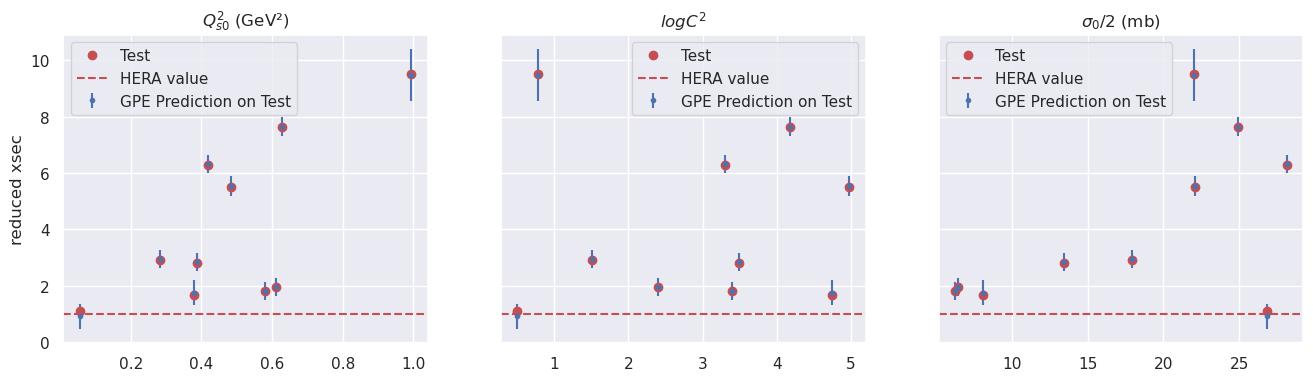

In [ ]:
# plot for first kinematical point, comparing training data value and gpe prediction
kp = 150
f, ax = plt.subplots(1, n_params, sharey = True, figsize=(16,4))
for i in range(0,n_params):
    ax[i].errorbar(myparams_test[:,i], pred_r[:,kp], fmt = '.', yerr = 10*err_r[:,kp], label = "GPE Prediction on Test")
    ax[i].plot(myparams_test[:,i], training_set_test[:,kp], 'ro', label = 'Test')
    ax[i].axhline(exp[kp],  color = 'r', linestyle = '--', label = 'HERA value')
    ax[i].set_title(param_names[i])
    ax[i].legend()

# ax[1].set_xscale("log")    
ax[0].set_ylabel("reduced xsec")

Text(0, 0.5, 'z score')

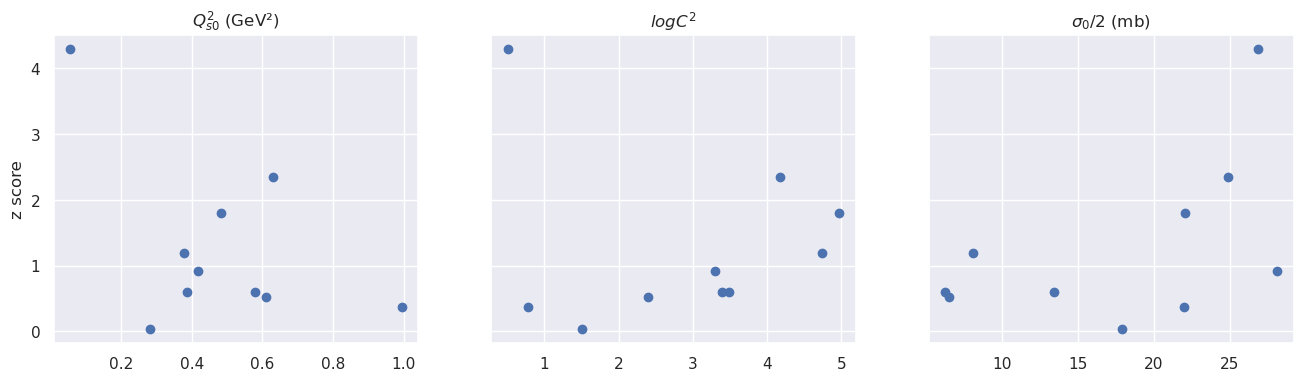

In [ ]:
# plot for first kinematical point, comparing training data value and gpe prediction
kp = 50
f, ax = plt.subplots(1, n_params, sharey = True, figsize=(16,4))
for i in range(0,n_params):
    ax[i].plot(myparams_test[:,i], np.abs(pred_r[:,kp] - training_set_test[:,kp]) / err_r[:,kp], 'o')
    ax[i].set_title(param_names[i])

ax[0].set_ylabel("z score")

In [ ]:
# are there still negative values in the err_r
for i in range(len(exp)):
    for num in err_r[:,i]:
        if num < 0:
            print(num, end=" ")

In [ ]:
#l_bounds = [0.01, 0.5, 1.0, 16.0] # Qs0² , ec , C², sigma0/2
l_bound_c = 0.001 #0.5
u_bound_c = 3. # 5
l_bounds = [0.01, l_bound_c, 1.0] # 
u_bounds = [0.40, u_bound_c, 10.0] 
#l_bounds = [0.01, 1.0, l_bound_c, 5.0] # 
#u_bounds = [0.2 24.0,, u_bound_c, 30.0] 
#l_bounds = [0.01, 0.5, 1.0, 10.0] # Qs0² , ec , C², sigma0/2
#u_bounds = [0.2, 20.0, 20.0, 30.0]
# l_bounds = [0.01, 0.5, 1.0, 10.0] # Qs0² , ec , C², sigma0/2
# u_bounds = [0.2, 20.0, 20.0, 30.0]
mylimits = np.array([l_bounds, u_bounds])
n_walkers = 50
n_burn = 1000
n_samples = 2000
p0 = np.random.uniform(l_bounds, u_bounds, size = (n_walkers,n_params))
sampler1 = emcee_sampler(n_walkers, n_params, log_posterior, l_bounds, u_bounds, emulators, exp, exp_err)
paramsamples = return_samples(p0,l_bounds, u_bounds, n_walkers, n_params, n_samples, n_burn, sampler1)

for i in range(n_params): # print means
    print(param_names[i] + "= {0:.3f}".format(np.mean(paramsamples[:,i])))

print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler1.acceptance_fraction)))

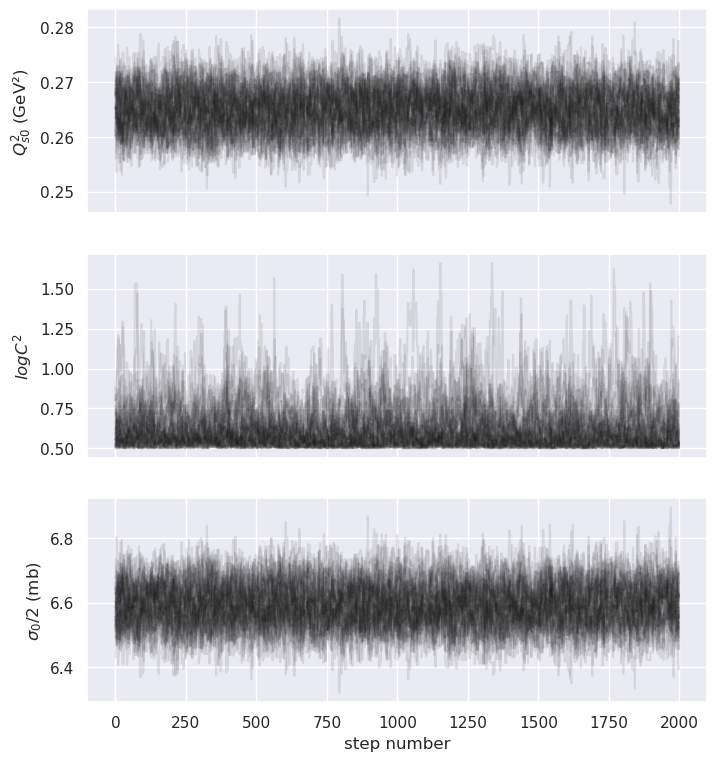

In [ ]:
fig, axes = plt.subplots(n_params, 1, sharex = True, figsize = (8, 9))
for i in range(n_params):
    axes[i].plot(sampler1.chain[:,:,i].T, color = 'k', alpha = 0.1)
    axes[i].set_ylabel(param_names[i])
    axes[-1].set_xlabel('step number')

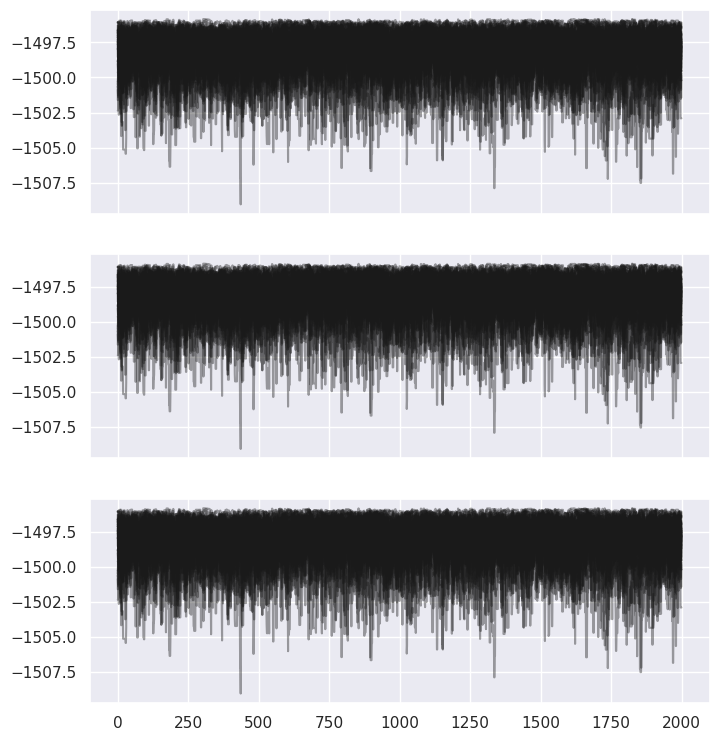

In [ ]:
fig, axes = plt.subplots(n_params, 1, sharex = True, figsize = (8, 9))
for i in range(n_params):
    axes[i].plot(sampler1.get_log_prob(), color = 'k', alpha = 0.4)
    #axes[i].set_ylabel('log probability')
    #axes[-1].set_xlabel('step number')

Quantiles:
[(0.16, 0.2610993620460321), (0.5, 0.2648459342240793), (0.84, 0.2686400370210735)]
Quantiles:
[(0.16, 0.5170253516166701), (0.5, 0.5691706778485512), (0.84, 0.6896538311580258)]
Quantiles:
[(0.16, 6.52937047989289), (0.5, 6.592890084396824), (0.84, 6.657583813588118)]


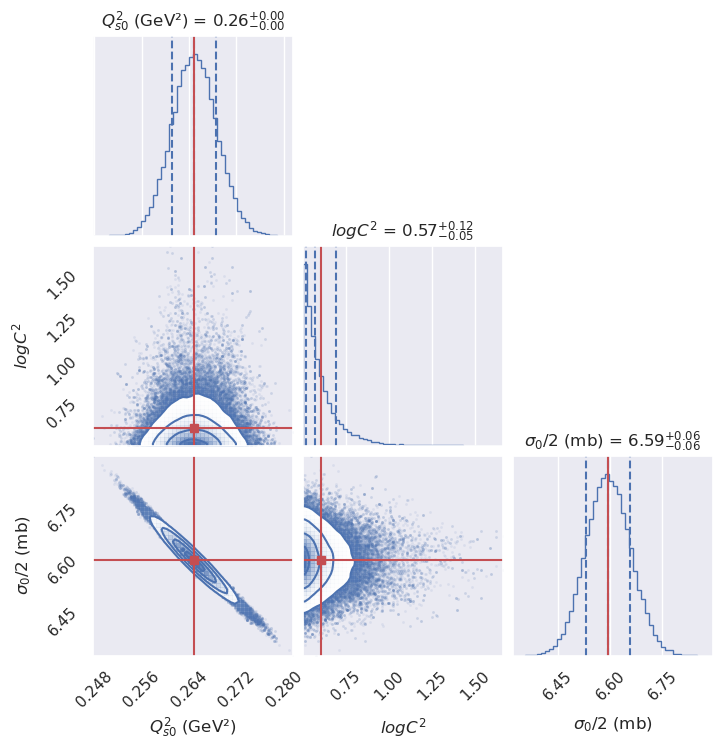

In [ ]:
figure = corner.corner(
    paramsamples,
    labels = param_names,
    plot_contours = True,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True, # title_fmt = '.3f'
    title_kwargs={"fontsize": 12}, 
    color = 'b',
    bins = 50,
    smooth = True,
    verbose = True,
    #plot_density = True,
    fillcontours = True, # 
    hist2d_kwargs = {"plot_density": True} # conto
)

ndim = n_params
axes = np.array(figure.axes).reshape((ndim, ndim))

for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(np.mean(paramsamples[:,i]), color="r")
    #if i == 1:
        #ax.set_xscale("log")
        #ax.set_yscale("log")

# Loop over the histograms
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(np.mean(paramsamples[:,xi]), color="r")
        ax.axhline(np.mean(paramsamples[:,yi]), color="r")
        ax.plot(np.mean(paramsamples[:,xi]), np.mean(paramsamples[:,yi]), "sr")

In [ ]:
#figure.savefig('figs/{}_{}_{}_{}.png'.format(fig_label, 'linearec', 'all', 'correcterr'))

In [ ]:
# space for validating() the gpe emulator
# z = np.zeros(20)
# ems = []
# prims = []
# for i in range(20):
#     prim = i + 2
#     prims.append(prim)
#     emulators0 = train_PCA_GPE(training_set, myparams, ss = StandardScaler(), primary_components = prim)
#     ems.append(emulators0)
#     pred_rs, err_rs = return_predictions(ems[i], myparams_test, return_std_ = True)
#     z_mean = []
#     for f in range(np.shape(pred_rs)[1]):
#         zs = np.mean(np.abs((pred_rs[:,f] - training_set_test[:,f]) / pred_rs[:,f]))
#         z_mean.append(zs)
#     z[i] = np.mean(z_mean)
#     #z[i] = emulators0[3]
#         #z[i] = np.mean(np.abs(err_rs))

# npc = np.where( z == np.amin(z, axis = 0))[0][0] + 2
# npc = 8
# plt.plot(prims, z, '.')